## Prepare data in Colab enviornment

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
! rm -rf /content/nima
! cp -r /gdrive/MyDrive/img-quality-assesment/nima/ /content/

# unzip the file
! mkdir /content/nima-dataset
! unzip -q /gdrive/MyDrive/nima-dataset/tid2013.zip -d /content/nima-dataset/

#### Install libraries

In [3]:
! pip install livelossplot kaggle --quiet

Upload to kaggle

In [4]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras

# Start : In local docker only
# import sys
# sys.path.append('../')
# End : In local docker only


import nima as nima

### Load Dataset

In [2]:
! rm -rf /content/nima
! cp -r /gdrive/MyDrive/img-quality-assesment/nima/ /content/

In [10]:
from nima.utils.tid_dataset_utils import load_tid_data
from nima.config import DATASET_DIR
from nima.utils.ava_downloader import print_msg

p_weights_dir = '/gdrive/MyDrive/img-quality-assesment/colab-models/'
p_dataset_dir = '/content/nima-dataset'
p_model_name = 'efficientnet'
p_batch_size = 64
p_epochs = 100
p_sample_size=None
p_verbose = 1
p_freeze_base = True

tid_dataset_dir = TID_DATASET_DIR if p_dataset_dir is None else p_dataset_dir
tid_images_dir = os.path.join(tid_dataset_dir, 'distorted_images')
img_format = 'bmp'
print_msg(f'Images directory {tid_images_dir}')

# Load the dataset
x_col, y_cols = 'image_id', 'mean'
df_train, df_valid, df_test = load_tid_data(tid_dataset_dir, p_sample_size)
print_msg(f'Train length : {len(df_train)} | Test lenght : {len(df_test)}')
assert len(df_train) > 0 and len(df_valid) > 0 and len(df_test) > 0, 'Empty dataframe'
train_batch_size = p_batch_size
valid_batch_size = min(train_batch_size - 32, 32)
test_batch_size = min(p_batch_size, 32, len(df_test))

df_train.head()

Images directory /content/nima-dataset/distorted_images
	Number of samples picked 3000
Train length : 2160 | Test lenght : 300


,image_id,mean,std
0,i19_05_4,0.444444,0.09623
1,i03_09_4,0.415954,0.11304
2,i18_19_1,0.571429,0.12404
3,i17_07_2,0.517543,0.12497
4,i23_09_3,0.633987,0.14723


In [6]:
from glob import glob 
# change extension to lower
files = glob(os.path.join(tid_images_dir, '*.BMP'))
for file in files:
    os.rename(file, file.replace('.BMP', '.bmp'))


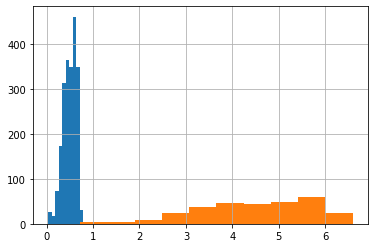

In [7]:
_ = df_train['mean'].hist(), df_test['mean'].hist()

### Create Model

In [11]:
from nima.model.data_generator import TrainDataGenerator, TestDataGenerator
from nima.model.model_builder import NIMA, get_model_weight_name, TechnicalModel
from nima.config import INPUT_SHAPE, CROP_SHAPE, MODEL_BUILD_TYPE

p_weight_path = None #'/gdrive/MyDrive/img-quality-assesment/colab-models/EfficientNetB3_technical.hdf5'
# Form the NIMA Aesthetic Model
nima_tech_cnn = TechnicalModel(p_model_name, weights_dir=p_weights_dir,
                                input_shape=INPUT_SHAPE, crop_size=CROP_SHAPE,
                                base_cnn_weight='imagenet')

# Build the model for training
nima_tech_cnn.build(0.75)

# freeze base layers
nima_tech_cnn.freeze_base_layers()

# weights are given load them 
if p_weight_path is not None:
    print_msg('Loading existing weights', 1)
    nima_tech_cnn.model.load_weights(p_weight_path)
  
nima_tech_cnn.compile()
# nima_tech_cnn.model.summary()

	Base CNN module - tensorflow.keras.applications.efficientnet.EfficientNetB3
	Freezing base CNN's layers.
	Model compiled successfully.


##### Train the model

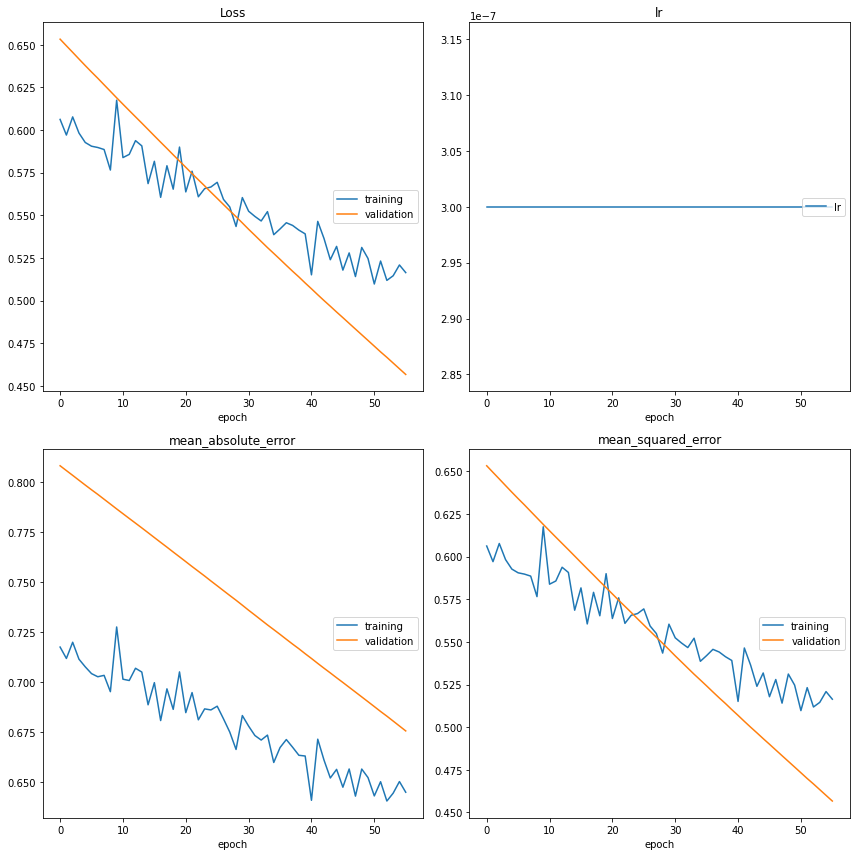

Epoch 57/100
19/34 [===============>..............] - ETA: 1:36 - loss: 0.5125 - mean_absolute_error: 0.6386 - mean_squared_error: 0.5125

In [ ]:
train_generator = TrainDataGenerator(df_train, tid_images_dir, x_col=x_col, y_col=y_cols,
                                        img_format=img_format, num_classes=1,
                                        preprocess_input=nima_tech_cnn.get_preprocess_function(),
                                        batch_size=train_batch_size, input_size=INPUT_SHAPE, crop_size=CROP_SHAPE)
valid_generator = TrainDataGenerator(df_valid, tid_images_dir, x_col, y_cols, img_format=img_format, num_classes=1,
                                        preprocess_input=nima_tech_cnn.get_preprocess_function(),
                                        batch_size=valid_batch_size, input_size=INPUT_SHAPE, crop_size=CROP_SHAPE)

# Train the model
print_msg("Training Technical Model...")
print_msg(f'Training Batch size {train_batch_size}', 1)
train_result_df = nima_tech_cnn.train_model(train_generator, valid_generator, epochs=p_epochs,
                                            verbose=p_verbose)
train_result_df.head()

#### Test and evaluate the model

In [ ]:
print_msg("Testing Model...")
# Get the generator
test_generator = TestDataGenerator(df_test, tid_images_dir, x_col=x_col, y_col=y_cols,
                                    img_format=img_format, num_classes=1,
                                    preprocess_input=nima_tech_cnn.get_preprocess_function(),
                                    batch_size=test_batch_size, input_size=INPUT_SHAPE)
eval_result, df_test = nima_tech_cnn.evaluate_model(df_test, test_generator, results_dir=p_weights_dir)

df_test

In [8]:
from nima.model.model_builder import get_naming_prefix
from nima.utils.tid_dataset_utils import TID_MAX_MEAN_SCORE

prefix=None
results_dir = p_weights_dir
eval_result = nima_tech_cnn.model.evaluate(test_generator)
print_msg(f"loss({nima_tech_cnn.loss}) : {eval_result[0]} | accuracy({nima_tech_cnn.metrics}) : {eval_result[1:]}", 1)
# predict the values from model
predictions = nima_tech_cnn.model.predict(test_generator)
df_test['pred_mean'] = predictions 
predict_df_filename = get_naming_prefix(nima_tech_cnn.model_type,
                                        nima_tech_cnn.model_class_name,
                                        prefix) + f'_pred.csv'
predict_file = os.path.join(results_dir, predict_df_filename)
print_msg(f'saving predictions to {predict_file}', 1)
df_test.to_csv(predict_file, index=False)
df_test.head()

10/10 [==============================] - 2s 141ms/step - loss: 0.4895 - mean_absolute_error: 0.6997 - mean_squared_error: 0.4895
	loss(mean_squared_error) : 0.4895125925540924 | accuracy(['mean_absolute_error', 'mean_squared_error']) : [0.6996510624885559, 0.4895125925540924]
	saving predictions to /gdrive/MyDrive/img-quality-assesment/colab-models/EfficientNetB3_technical_pred.csv


,image_id,mean,std,pred_mean
0,i23_04_2,0.627451,0.15498,0.300473
1,i18_03_2,0.505556,0.07866,0.300685
2,i09_19_5,0.387206,0.12943,0.300263
3,i21_22_1,0.595238,0.12518,0.300847
4,i20_08_5,0.287749,0.11304,0.300248


In [10]:
# view the accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(df_test['mean'].to_numpy(), df_test['pred_mean'].to_numpy())
mae = mean_absolute_error(df_test['mean'].to_numpy(), df_test['pred_mean'].to_numpy())
r2 = mean_absolute_error(df_test['mean'].to_numpy(), df_test['pred_mean'].to_numpy())

print_msg(f"mse : {mse:.3f}, mae : {mae:.3f}, r2_score : {r2:.3f}")

mse : 0.059, mae : 0.211, r2_score : 0.211


#### Test the model for one image

In [ ]:
from nima.utils import image_utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image = df_test.iloc[0]['image_id']
y_true = df_test.iloc[0]['rating']

image_path = os.path.join(tid_images_dir, f'{image}.bmp')
plt.imshow(x)
target_size = INPUT_SHAPE

x = load_img(image_path, target_size=(target_size[0], target_size[1]))  # load the image in pillow format
x = img_to_array(x)  # convert to numpy array
x = x.reshape(1, *x.shape)
x = nima_technical_cnn.preprocess_input(x)
predict = nima_technical_cnn.model.predict(x)
y_true, predict[0]

(5.575, array([8.660821], dtype=float32))